In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler

import os
import h5py
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
device = 'cuda'
from time import time

import losses
from utils import ScatteringProblemForward

In [2]:
filename_out    = 'output/ff_nn.pt'
# Model to load and continue training. Ignored if empty string
filename_in     = ''
# Compute device to perform the training on, 'cuda' or 'cpu'
device          = 'cuda'
# Use interactive visualization of losses and other plots. Requires visdom
interactive_visualization = False # check first how this visdom works
# Run a list of python functions at test time after eacch epoch
# See toy_modes_train.py for reference example
test_time_functions = []

#######################
#  Training schedule  #
#######################

# Initial learning rate
lr_init         = 1.0e-3
#Batch size
batch_size      = 128
# Total number of epochs to train for
n_epochs        = 50

# End the epoch after this many iterations (or when the train loader is exhausted)
n_its_per_epoch = 200
# For the first n epochs, train with a much lower learning rate. This can be
# helpful if the model immediately explodes.
pre_low_lr      = 0
# Decay exponentially each epoch, to final_decay*lr_init at the last epoch.
final_decay     = 0.02
# L2 weight regularization of model parameters
l2_weight_reg   = 1e-5
# Parameters beta1, beta2 of the Adam optimizer
adam_betas = (0.9, 0.95)

#####################
#  Data dimensions  #
#####################
ndim_x_class     = 3
ndim_x_features     = 7

ndim_y     = 512

############
#  Losses  #
############

train_forward_mmd    = True

lambd_mmd_for_class    = 10
lambd_mmd_for_feature  = 50

# For noisy forward processes, the sigma on y (assumed equal in all dimensions).
# This is only used if mmd_back_weighted of train_max_likelihoiod are True.
y_uncertainty_sigma = 0.12 * 4

mmd_forw_kernels = [(0.2, 1/2), (1.5, 1/2), (3.0, 1/2)]
mmd_back_kernels = [(0.2, 1/2), (0.2, 1/2), (0.2, 1/2)]
mmd_back_weighted = True

###########
#  Model  #
###########

# Initialize the model parameters from a normal distribution with this sigma
init_scale = 0.10
#
N_blocks   = 25
#
exponent_clamping = 2.0
#
hidden_layer_sizes = 1024
#
use_permutation = True
#
verbose_construction = False

In [3]:
lp = ScatteringProblemForward( device,  batch_size, ndim_x_class, ndim_x_features, ndim_y, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, 
                        lambd_mmd_for_class, lambd_mmd_for_feature, mmd_back_weighted, y_uncertainty_sigma, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [4]:
lp.read_data('/home/slaskina/simulations')
lp.normalize_inputs()

In [5]:
lp.create_loaders()

In [6]:
class ForwardScatteringLinear(nn.Module):
    def __init__(self, in_dim, out_dim,N_blocks, hidden_layers) -> None:
        super().__init__()
        self.linear_in = nn.Linear(in_dim, hidden_layers)
        self.linear_middle = nn.Linear(hidden_layers,hidden_layers)
        self.linear_out = nn.Linear(hidden_layers,out_dim)
        self.N_blocks = N_blocks
    def forward(self, x):
        x = F.relu(self.linear_in(x))
        for _ in range(self.N_blocks):
            x = F.relu(self.linear_middle(x))
        x = self.linear_out(x)
        return x
model_simple_linear =ForwardScatteringLinear(ndim_y,ndim_x_class+ndim_x_features,N_blocks, hidden_layer_sizes)

In [7]:
lp.set_model(model_simple_linear)
lp.set_optimizer()

In [8]:
lp.train()

Epoch 0: training loss: 2.446790402982293, test loss: 2.4372751349988193
Epoch 1: training loss: 2.451392455798824, test loss: 2.4752177259196406
Epoch 2: training loss: 2.4533107513334693, test loss: 2.3982807449672534
Epoch 3: training loss: 2.4633841645426866, test loss: 2.4024302855781885
Epoch 4: training loss: 2.4555064061792886, test loss: 2.4399429974348648
Epoch 5: training loss: 2.4297931906653614, test loss: 2.4674751447594683
Epoch 6: training loss: 2.454126891566486, test loss: 2.4234848955403203
Epoch 7: training loss: 2.441699100703728, test loss: 2.4224216523377793
Epoch 8: training loss: 2.4454544564572775, test loss: 2.441375494003296
Epoch 9: training loss: 2.465873385347971, test loss: 2.412149087242458
Epoch 10: training loss: 2.488720203318247, test loss: 2.4326063705527265
Epoch 11: training loss: 2.4430227875709534, test loss: 2.4440788082454517
Epoch 12: training loss: 2.4552535545535203, test loss: 2.426415417505347
Epoch 13: training loss: 2.4674211406126254,

In [9]:
df_train = lp.create_table_from_outcomes(lp.make_prediction(lp.train_indices), lp.train_indices)
df_val = lp.create_table_from_outcomes(lp.make_prediction(lp.val_indices), lp.val_indices) 
df_test = lp.create_table_from_outcomes(lp.make_prediction(lp.test_indices), lp.test_indices)

ValueError: operands could not be broadcast together with shapes (10500,7) (509,) (10500,7) 

In [ ]:

from visualizations import plot_outcomes_identified, describe_false_shapes, describe_positive_shapes


Accuracy is 23.50%
MSE for radius per shape for correctly identified instances as follows: sphere: inf, hardsphere: 9523.2949 and cylinder: 542317.1875
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: inf, hardsphere: 484.3167 and cylinder: 3012.4629
MSE for cylinder length for correctly identified instances: 1415.6625
MSE for cylinder length polydispersity for correctly identified instances: 92414.1172
MSE for cylinder length for correctly identified instances: 22851.7344


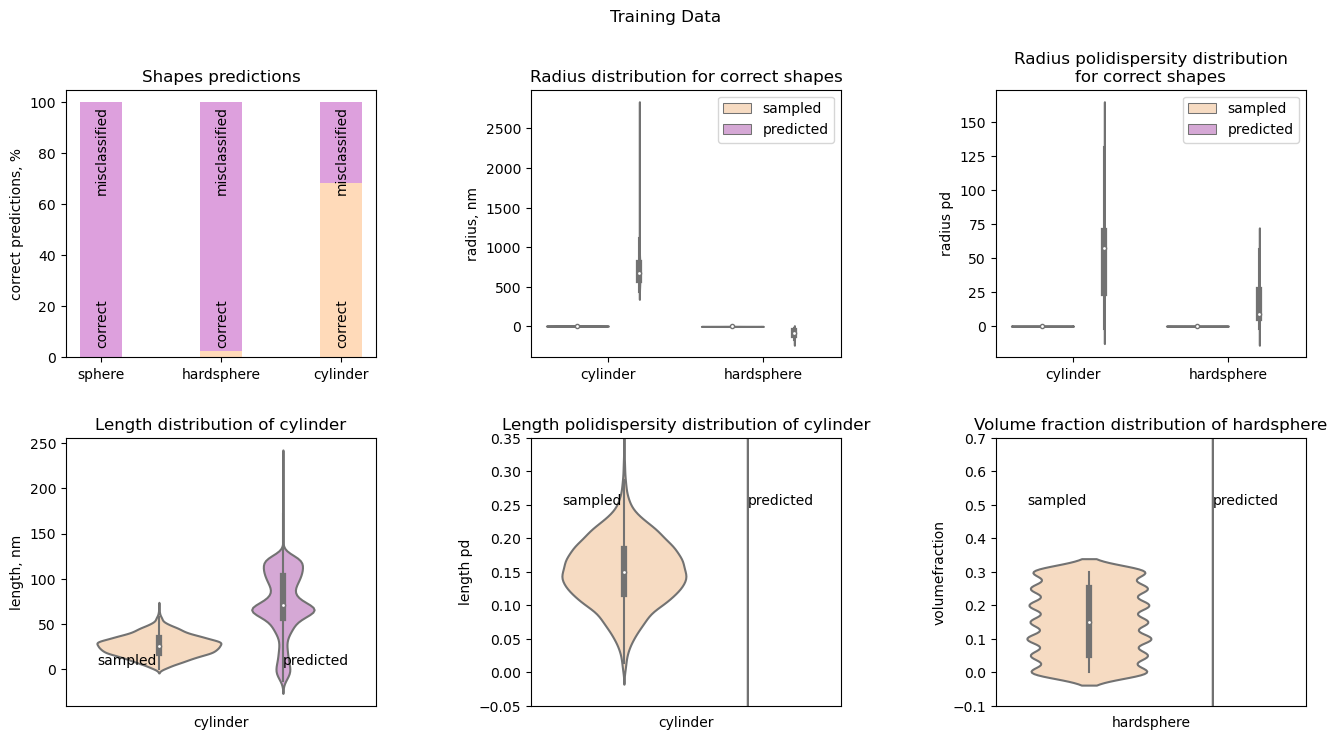

In [ ]:
plot_outcomes_identified(df_train, 'Training')

Accuracy is 23.53%
MSE for radius per shape for correctly identified instances as follows: sphere: inf, hardsphere: 7213.0762 and cylinder: 519744.0000
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: inf, hardsphere: 358.6791 and cylinder: 3132.2786
MSE for cylinder length for correctly identified instances: 1440.7982
MSE for cylinder length polydispersity for correctly identified instances: 89565.1875
MSE for cylinder length for correctly identified instances: 17510.9375


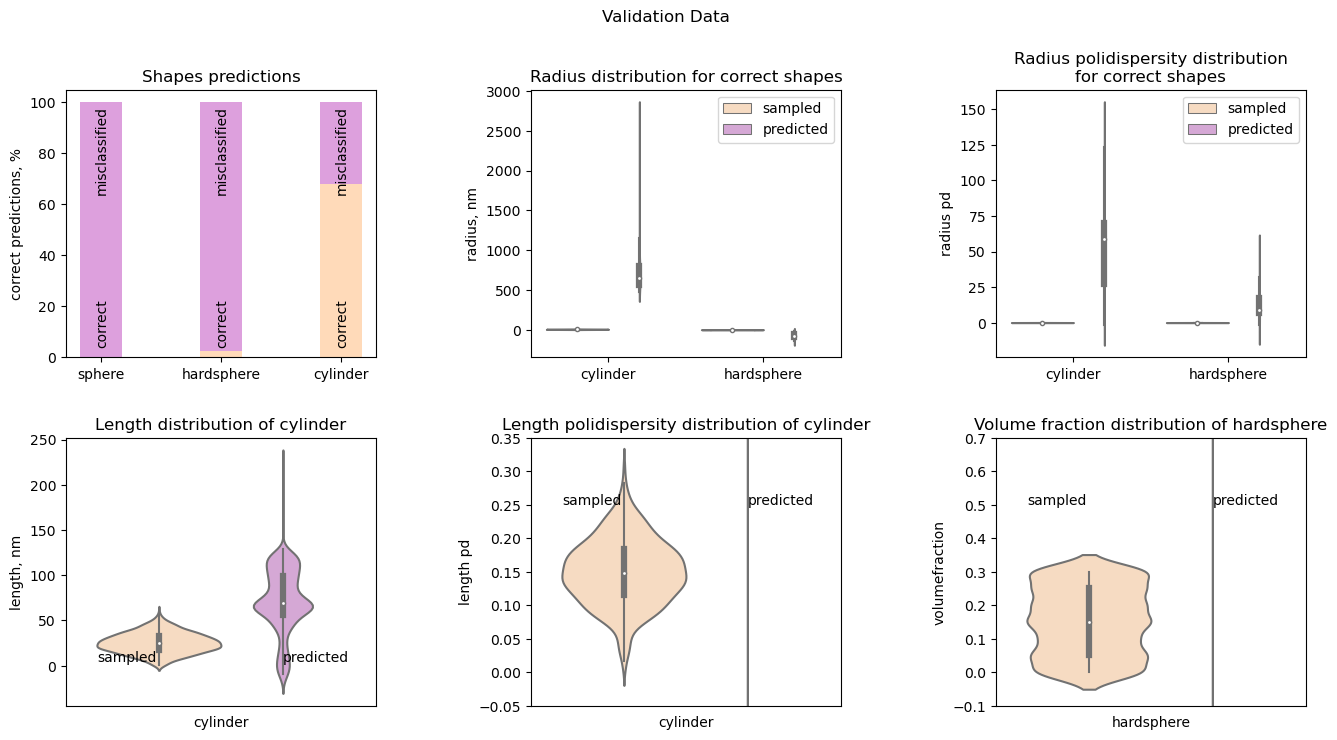

In [ ]:
plot_outcomes_identified(df_val, 'Validation')

Accuracy is 24.47%
MSE for radius per shape for correctly identified instances as follows: sphere: inf, hardsphere: 6624.9590 and cylinder: 495615.1875
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: inf, hardsphere: 884.5634 and cylinder: 2825.9124
MSE for cylinder length for correctly identified instances: 1187.4218
MSE for cylinder length polydispersity for correctly identified instances: 82183.2188
MSE for cylinder length for correctly identified instances: 19154.9492


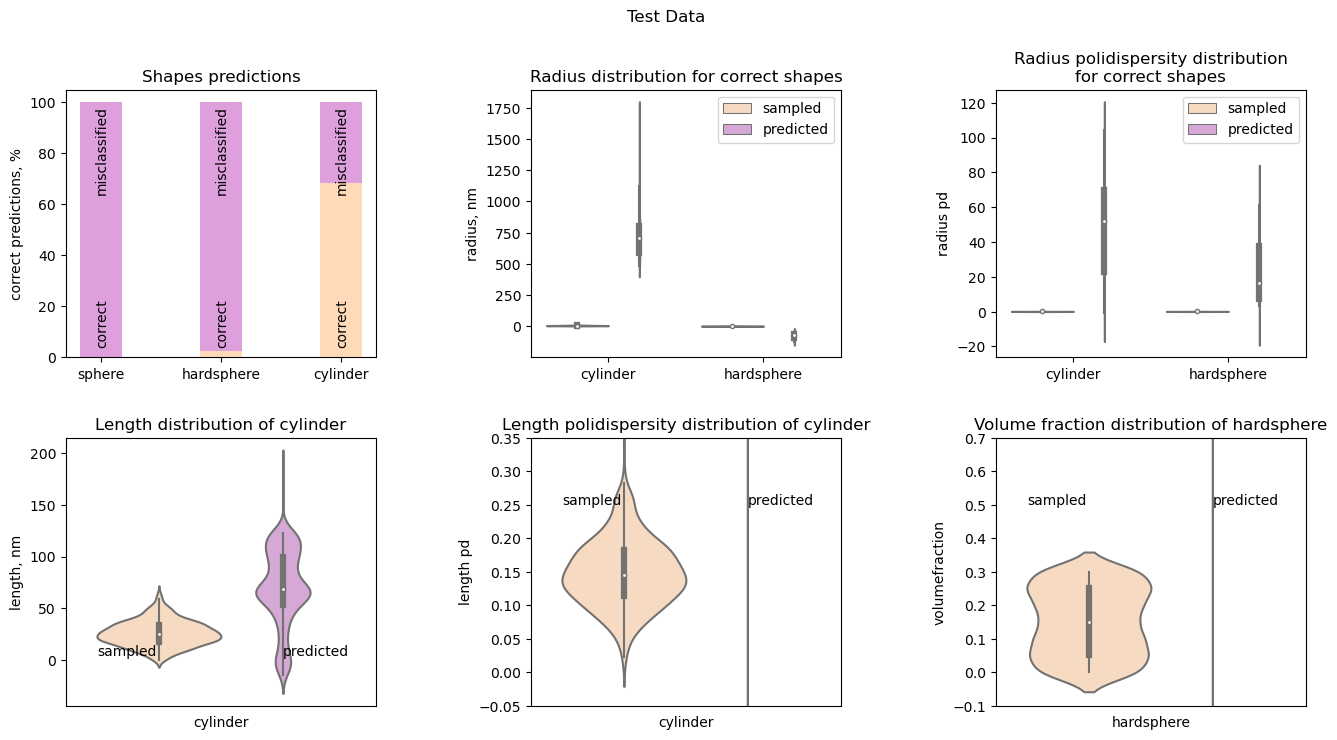

In [ ]:
plot_outcomes_identified(df_test, 'Test')

In [ ]:
labels,inputs = utils.read_data('/home/slaskina/simulations2', ndim_x_class, ndim_x_features, ndim_y)

In [ ]:
(train_indices, val_indices, test_indices), train_loader, test_loader = utils.create_loaders(inputs, labels, batch_size)

In [ ]:
class ForwardScatteringLinear(nn.Module):
    def __init__(self, in_dim, out_dim,N_blocks, hidden_layers) -> None:
        super().__init__()
        self.linear_in = nn.Linear(in_dim, hidden_layers)
        self.linear_middle = nn.Linear(hidden_layers,hidden_layers)
        self.linear_out = nn.Linear(hidden_layers,out_dim)
        self.N_blocks = N_blocks
    def forward(self, x):
        x = F.relu(self.linear_in(x))
        for _ in range(self.N_blocks):
            x = F.relu(self.linear_middle(x))
        x = self.linear_out(x)
        return x

In [ ]:
model_simple_linear = ForwardScatteringLinear(ndim_y,ndim_x_class+ndim_x_features,N_blocks, hidden_layer_sizes).to(device)


In [ ]:
def params_trainable(model):
    params_trainable = list(filter(lambda p: p.requires_grad, model.parameters()))
    for p in params_trainable:
        p.data = init_scale * torch.randn(p.data.shape).to(device)
    return params_trainable

def optimizer(model):
    optim = torch.optim.Adam(params_trainable(model), lr=lr_init, betas=adam_betas, eps=1e-6, weight_decay=l2_weight_reg)
    return optim 

gamma = (final_decay)**(1./n_epochs)

def optim_step(optim):
    #for p in params_trainable:
        #print(torch.mean(torch.abs(p.grad.data)).item())
    optim.step()
    optim.zero_grad()

def save(name, model, optim):
    torch.save({'opt':optim.state_dict(),
                'net':model.state_dict()}, name)

def load(name, model, optim):
    state_dicts = torch.load(name)
    model.load_state_dict(state_dicts['net'])
    try:
        optim.load_state_dict(state_dicts['opt'])
    except ValueError:
        print('Cannot load optimizer for some reason or other')

In [ ]:

def noise_batch(ndim):
    return torch.randn(batch_size, ndim).to(device)


def loss_forward_mmd(x_class, x_features, pred):
    pred_class, pred_features = pred[:,:3], pred[:, 3:]
    MMD_class = losses.backward_mmd(x_class, pred_class) 
    MMD_features = losses.backward_mmd(x_features, pred_features)
    if mmd_back_weighted:
        MMD_class *= torch.exp(- 0.5 / y_uncertainty_sigma**2 * losses.l2_dist_matrix(pred, pred))
        MMD_features *= torch.exp(- 0.5 / y_uncertainty_sigma**2 * losses.l2_dist_matrix(pred, pred))
    return lambd_mmd_for_class * torch.mean(MMD_class)+lambd_mmd_for_feature * torch.mean(MMD_features)

def train_epoch(model, optim, i_epoch, loader,  test=False):
    if not test:
        model.train()
        loader = train_loader

    if test:
        model.eval()
        loader = test_loader
        nograd = torch.no_grad()
        nograd.__enter__()


    batch_idx = 0
    loss_history = []

    for y,x in loader: # because y is  actualy the result of x

        if batch_idx > n_its_per_epoch:
            break

        batch_idx += 1

        x, y = x.to(device), y.to(device)
        x_class, x_features = x[:, :3],x[:, 3:]


        
        pred = model(y).reshape(-1,10)
        loss = loss_forward_mmd(x_class, x_features, pred)
        loss_history.append([loss.item()]) # lisr of lists: list for each batch
        
        if not test:
            loss.backward()
            optim_step(optim)

    if test:
        nograd.__exit__(None, None, None)
    return np.mean(loss_history, axis=0)

def train(model, optim, train_loader, test_loader):

    try:
        t_start = time()
        for i_epoch in range(-pre_low_lr, n_epochs):

            if i_epoch < 0:
                for param_group in optim.param_groups:
                    param_group['lr'] = lr_init * 1e-1

            train_losses = train_epoch(model, optim, i_epoch, train_loader) # mean over batches
            test_losses  = train_epoch(model, optim, i_epoch, test_loader, test=True)
            t = np.concatenate([train_losses, test_losses])
            print('Epoch {i_e}: training loss: {tl}, test loss: {testl}'.format(i_e = i_epoch, tl = t[0], testl = t[1]))


    except:
        save(filename_out + '_ABORT',model, optim)
        raise

    finally:
        print("\n\nTraining took %f minutes\n\n" % ((time()-t_start)/60.))
        save(filename_out,model, optim)


In [ ]:
train(model_simple_linear, optimizer(model_simple_linear), train_loader, test_loader)

Epoch 0: training loss: 5.628174828320015, test loss: 5.536475036455237
Epoch 1: training loss: 5.640933653203453, test loss: 5.495231193044911
Epoch 2: training loss: 5.5592190114463245, test loss: 5.507661695065706
Epoch 3: training loss: 5.645601452850714, test loss: 5.570639672486679
Epoch 4: training loss: 5.5756530238360895, test loss: 5.666296875995139
Epoch 5: training loss: 5.613824222146011, test loss: 5.381419015967327
Epoch 6: training loss: 5.613710444147994, test loss: 5.472686746846074
Epoch 7: training loss: 5.618628833352066, test loss: 5.509899678437606
Epoch 8: training loss: 5.652746973968133, test loss: 5.4928675941798994
Epoch 9: training loss: 5.583875725908977, test loss: 5.459086563276208
Epoch 10: training loss: 5.5614808361704755, test loss: 5.513136801512345
Epoch 11: training loss: 5.5993891111234335, test loss: 5.472175307895826
Epoch 12: training loss: 5.570936342565025, test loss: 5.448760571687118
Epoch 13: training loss: 5.59003169362138, test loss: 5.

In [ ]:
import seaborn as sns
from sklearn.metrics import mean_squared_error
import pandas as pd

In [ ]:
def create_table_from_outcome(pred, sampled_inputs):
    df = pd.DataFrame(columns = ['true_shape', 'pred_shape', 'radius','pred_radius'], index = [])
    df['true_shape'] = sampled_inputs[:,:3].argmax(axis=1)
    df['pred_shape'] = pred[:,:3].argmax(axis=1)
    df['radius'] = np.take_along_axis(sampled_inputs[:,3:6],df.true_shape.values.reshape(-1,1), axis=1)
    df['pred_radius'] = np.take_along_axis(pred[:,3:6],df.pred_shape.values.reshape(-1,1), axis=1)
    df['radius_pd'] = sampled_inputs[:,6]
    df['pred_radius_pd'] = pred[:,6]
    df['length'] = sampled_inputs[:,7]
    df['pred_length'] = np.where(df.pred_shape.values ==2, pred[:,7], 0) # only those identified as cylinder should have lengh and pd_length
    df['length_pd'] = sampled_inputs[:,8]
    df['pred_length_pd'] = np.where(df.pred_shape.values ==2, pred[:,8], 0)
    df['volfraction'] = sampled_inputs[:,9]
    df['pred_volfraction'] = np.where(df.pred_shape.values ==1, pred[:,9], 0)
    return df

In [ ]:
def make_prediction(labels, model):
    return model(labels)


In [ ]:
predicted_features = make_prediction(inputs[test_indices], model_simple_linear.to('cpu')).detach().numpy()

In [ ]:
df = create_table_from_outcome(predicted_features, labels[test_indices])

In [ ]:
def MSE(sampled, predicted):
    if len(sampled) == 0:
        return np.inf
    else:
        return mean_squared_error(sampled, predicted)

In [ ]:
def outcomes(df, data_name):
    print('Accuracy is {0:.2%}'.format((df.true_shape == df.pred_shape).sum()/len(df)))
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 8))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.3)
    shapes = ['sphere', 'hardsphere', 'cylinder']
    # shape classified correctly
    correct = [((df.true_shape == 0) & (df.pred_shape == 0)).sum(),((df.true_shape == 1) & (df.pred_shape == 1)).sum(),((df.true_shape == 2) & (df.pred_shape == 2)).sum()]
    wrong = [((df.true_shape == 0) & (df.pred_shape != 0)).sum(),((df.true_shape == 1) & (df.pred_shape != 1)).sum(),((df.true_shape == 2) & (df.pred_shape != 2)).sum()]
    correct = [correct[i]/(correct[i]+ wrong[i])*100 for i in range(len(correct))]
    wrong = [100-correct[i] for i in range(len(wrong))]
    ax = axes[0,0]
    ax.bar(shapes, correct, width=0.35, label='correct', color = 'peachpuff')
    ax.bar(shapes, wrong, width=0.35,bottom=correct, label='misclassified', color = 'plum')
    ax.set_ylabel('correct predictions, %')
    ax.set_title('Shapes predictions')
    ax.text(-0.05, 5, 'correct', rotation = 90)
    ax.text(0.95, 5, 'correct', rotation = 90)
    ax.text(1.95, 5, 'correct', rotation = 90)
    
    ax.text(-0.05, 65, 'misclassified', rotation = 90)
    ax.text(0.95, 65, 'misclassified', rotation = 90)
    ax.text(1.95, 65, 'misclassified', rotation = 90)

    # radius of a correctly identified shapes
    #print('Total radius MSE is {err:.2f}'.format(err= mean_squared_error(df.radius, df.pred_radius)))
    print('MSE for radius per shape for correctly identified instances as follows: sphere: {sMSE:.4f}, hardsphere: {hsMSE:.4f} and cylinder: {cMSE:.4f}'.format\
        (sMSE = MSE(df[(df.true_shape == 0) & (df.pred_shape == 0)].radius, df[(df.true_shape == 0) & (df.pred_shape == 0)].pred_radius), 
         hsMSE = MSE(df[(df.true_shape == 1) & (df.pred_shape == 1)].radius, df[(df.true_shape == 1) & (df.pred_shape == 1)].pred_radius),
         cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].radius, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_radius)))
      
    #print('Total radius MSE is {err:.2f}'.format(err= mean_squared_error(df.radius, df.pred_radius)))
    print('MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: {sMSE:.4f}, hardsphere: {hsMSE:.4f} and cylinder: {cMSE:.4f}'.format\
        (sMSE = MSE(df[(df.true_shape == 0) & (df.pred_shape == 0)].radius_pd, df[(df.true_shape == 0) & (df.pred_shape == 0)].pred_radius_pd), 
         hsMSE = MSE(df[(df.true_shape == 1) & (df.pred_shape == 1)].radius_pd, df[(df.true_shape == 1) & (df.pred_shape == 1)].pred_radius_pd),
         cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].radius_pd, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_radius_pd)))

    print('MSE for cylinder length for correctly identified instances: {cMSE:.4f}'.format\
        (cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].length, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_length)))
    print('MSE for cylinder length polydispersity for correctly identified instances: {cMSE:.4f}'.format\
        (cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].length_pd, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_length_pd)))
    print('MSE for cylinder length for correctly identified instances: {hMSE:.4f}'.format\
        (hMSE = MSE(df[(df.true_shape == 1) & (df.pred_shape == 1)].volfraction, df[(df.true_shape == 1) & (df.pred_shape == 1)].pred_volfraction)))
    #stacked df to create violinplots
    df_stacked = df[df.true_shape ==df.pred_shape].drop(columns = ['pred_shape']).set_index('true_shape').stack().reset_index().rename(columns = {'level_1':'feature', 0:'value'})
    df_stacked.loc[df_stacked.true_shape == 0, 'true_shape'] = "sphere"
    df_stacked.loc[df_stacked.true_shape == 1, 'true_shape'] = "hardsphere"
    df_stacked.loc[df_stacked.true_shape == 2, 'true_shape'] = "cylinder"

    ax = axes[0,1]
    data = df_stacked[(df_stacked.feature == 'radius')|(df_stacked.feature == 'pred_radius')]
    data.loc[data.feature == 'radius', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_radius', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False), x="true_shape", y="value", hue="feature", split = True, ax=ax, palette=['peachpuff', 'plum'])
    ax.set_title('Radius distribution for correct shapes')
    ax.set_ylabel("radius, nm")
    ax.set_xlabel("")
    ax.legend()

    ax = axes[0,2]
    data = df_stacked[(df_stacked.feature == 'radius_pd')|(df_stacked.feature == 'pred_radius_pd')]
    data.loc[data.feature == 'radius_pd', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_radius_pd', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False), x="true_shape", y="value", hue="feature", split = True, ax=ax, palette=['peachpuff', 'plum'])
    ax.set_title('Radius polidispersity distribution\nfor correct shapes')
    ax.legend()
    ax.set_ylabel("radius pd")
    ax.set_xlabel("")

    # length
    df_stacked = df.set_index(['true_shape', 'pred_shape']).stack().reset_index().rename(columns = {'level_2':'feature', 0:'value'}).assign(y=1)

    ax = axes[1,0]
    data = df_stacked[((df_stacked.feature == 'length')&(df_stacked.true_shape ==2))|((df_stacked.feature == 'pred_length')&(df_stacked.pred_shape == 2))]
    data.loc[data.feature == 'length', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_length', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False), x="y",y = "value", hue="feature",split = True, ax=ax, palette=['peachpuff', 'plum'] )
    ax.set_title('Length distribution of cylinder')
    ax.set_xlabel("cylinder")
    ax.set_ylabel("length, nm")
    ax.set_xticks([])
    ax.get_legend().remove()
    ax.text(-.4, 4.2, "sampled")
    ax.text(0.2, 4.2, "predicted")
    ax.set_ylim([-.5,6])

    ax = axes[1,1]
    data = df_stacked[((df_stacked.feature == 'length_pd')&(df_stacked.true_shape ==2))|((df_stacked.feature == 'pred_length_pd')&(df_stacked.pred_shape == 2))]
    data.loc[data.feature == 'length_pd', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_length_pd', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False),  x="y",y = "value", hue="feature", split = True, ax=ax, palette=['peachpuff', 'plum'])
    ax.set_title('Length polidispersity distribution of cylinder')
    ax.set_xlabel("cylinder")
    ax.set_ylabel("length pd")
    ax.set_xticks([])
    ax.get_legend().remove()
    ax.text(-.4, 0.25, "sampled")
    ax.text(0.2, 0.25, "predicted")
    ax.set_ylim([-0.05, 0.35])

    ax = axes[1,2]
    data = df_stacked[((df_stacked.feature == 'volfraction')&(df_stacked.true_shape ==1))|((df_stacked.feature == 'pred_volfraction')&(df_stacked.pred_shape == 1))]
    data.loc[data.feature == 'volfraction', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_volfraction', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False), x="y",y = "value", hue="feature", split = True, ax=ax, palette=['peachpuff', 'plum'])
    ax.set_title('Volume fraction distribution of hardsphere')
    ax.set_xlabel("hardsphere")
    ax.set_ylabel("volumefraction")
    ax.set_xticks([])
    ax.get_legend().remove()
    ax.text(-.4, 0.5, "sampled")
    ax.text(0.2, 0.5, "predicted")
    ax.set_ylim([-0.1, 0.7])

    plt.suptitle('{d} Data'.format(d = data_name))

In [ ]:
df

,true_shape,pred_shape,radius,pred_radius,radius_pd,pred_radius_pd,length,pred_length,length_pd,pred_length_pd,volfraction,pred_volfraction
0,1,0,0.045216,NaN,0.001380,NaN,0.000000,0.0,0.000000,0.0,0.0020,0.0
1,2,0,0.070165,NaN,0.001101,NaN,0.150698,0.0,0.001662,0.0,0.0000,0.0
2,2,0,0.062424,NaN,0.001047,NaN,0.231405,0.0,0.002579,0.0,0.0000,0.0
3,2,0,0.085984,NaN,0.001462,NaN,0.104506,0.0,0.001185,0.0,0.0000,0.0
4,1,0,0.053728,NaN,0.001396,NaN,0.000000,0.0,0.000000,0.0,0.0005,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1,0,0.002153,NaN,0.001035,NaN,0.000000,0.0,0.000000,0.0,0.0030,0.0
1496,0,0,0.079289,NaN,0.000708,NaN,0.000000,0.0,0.000000,0.0,0.0000,0.0
1497,2,0,0.027213,NaN,0.001588,NaN,0.341069,0.0,0.001263,0.0,0.0000,0.0
1498,0,0,0.068855,NaN,0.000642,NaN,0.000000,0.0,0.000000,0.0,0.0000,0.0


Accuracy is 33.07%


ValueError: Input contains NaN.

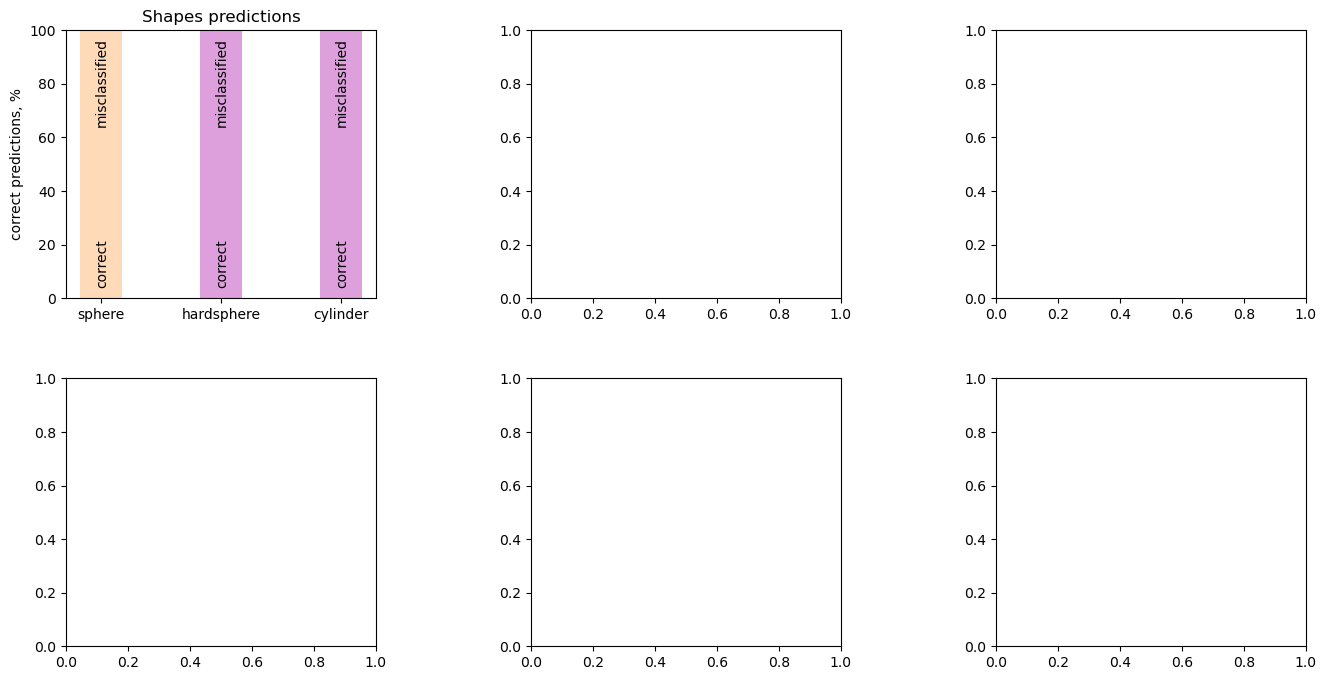

In [ ]:
outcomes(df, 'test')

In [ ]:
a = torch.rand(10,10)

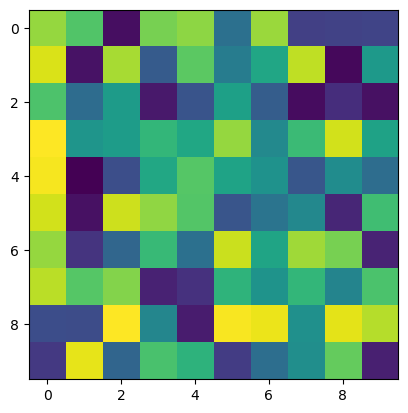

In [ ]:
plt.imshow(a)

In [ ]:
fft_a = torch.fft.fft2(a, norm = 'forward')
fft_a_scaled = torch.fft.fft2(a*100,  norm = 'forward')

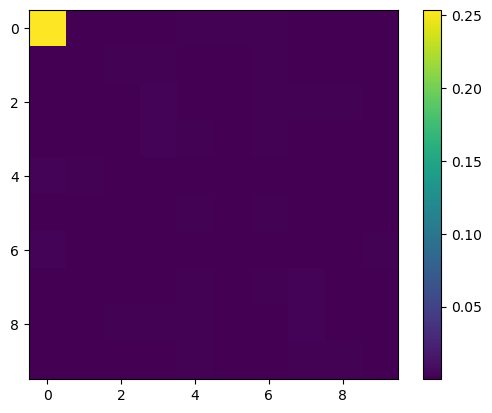

In [ ]:
img = plt.imshow(torch.abs(fft_a)**2)
plt.colorbar(img)

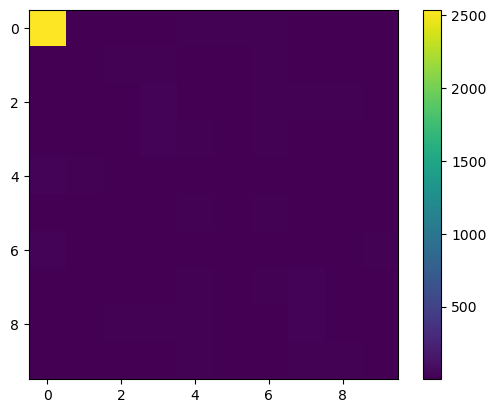

In [ ]:
img = plt.imshow(torch.abs(fft_a_scaled)**2)
plt.colorbar(img)